# RNA-DNAm: scBOND-Aug

The following tutorial demonstrate how to use scBOND-Aug variant with data augmentation using cell-type labels.

scBOND-Aug generates synthetic paired scRNA-seq and scDNAm profiles by recombining features from scRNA-seq and scDNAm data within the same cell type through random permutations (Methods). By expanding the training dataset in a biologically coherent manner, this strategy enables the model to learn a broader range of cross-modality correspondences while preserving intra-class consistency.

Note: Most of this tutorial is same as scBOND with more details of data pre-processing, model constructing, model training and evaluating. It’s prefered to see that first, because it has no different in parts mentioned above, but have more useful notes.

In [1]:
import scBond
from scBond.bond import Bond
import scanpy as sc

In [2]:
bond = Bond()

In [3]:
RNA_data = sc.read_h5ad('adata_rna.h5ad')
MET_data = sc.read_h5ad('adata_met.h5ad')

In [4]:
all_indices = MET_data.var.index.tolist()
MET_data.var['chrom'] = [idx[:4] if len(idx) >= 4 else idx for idx in all_indices]
MET_data.obs['cell_type'] = MET_data.obs['MajorType']
RNA_data.obs['cell_type'] = RNA_data.obs['MajorType']

In [5]:
from scBond.split_datasets import *

In [6]:
id_list = five_fold_split_dataset(RNA_data, MET_data)
train_id, validation_id, test_id = id_list[0]

In [7]:
bond.load_data(RNA_data, MET_data, train_id, test_id, validation_id)

[INFO] Bond: successfully load in data with

RNA data:
AnnData object with n_obs × n_vars = 4013 × 60606
    obs: 'fig2_tsne_0', 'fig2_tsne_1', 'fig2_umap_0', 'fig2_umap_1', 'MajorType', 'SubType', 'cell_type'

MET data:
AnnData object with n_obs × n_vars = 4013 × 309556
    obs: 'fig2_tsne_0', 'fig2_tsne_1', 'fig2_umap_0', 'fig2_umap_1', 'MajorType', 'SubType', 'cell_type'
    var: 'chrom'


In [8]:
bond.data_preprocessing()

[INFO] RNA preprocessing: normalize size factor.
[INFO] RNA preprocessing: log transform RNA data.
[INFO] RNA preprocessing: choose top 3000 genes for following training.
[INFO] MET preprocessing: Filtering features: min 29.0 cells (0.700%) per feature
[INFO] MET preprocessing: Performing missing value imputation using method: median
[INFO] MET preprocessing: Performing min-max scaling.


## Data augmentation with cell-type labels

Here we choose the parameter enable_augmentation=True, and scBOND-Aug will automatically generate randomly paired data as supplement for training.

In [9]:
bond.augmentation(enable_augmentation=True)

[INFO] Bond: using data augmentation with cell type labels.


Warning: To use data augmentation with cell-type labels, you should ensure that there has cell_type label in RNA_data.obs and MET_data.obs.

In [10]:
chrom_list = []
last_one = ''
for i in range(len(bond.MET_data_p.var.chrom)):
    temp = bond.MET_data_p.var.chrom[i]
    if temp[0 : 3] == 'chr':
        if not temp == last_one:
            chrom_list.append(1)
            last_one = temp
        else:
            chrom_list[-1] += 1
    else:
        chrom_list[-1] += 1
        
print(chrom_list, end="")

[22471, 23784, 19482, 18767, 17739, 16740, 15537, 14281, 11873, 94526, 12268, 14783, 2012, 1]

In [11]:
sum(chrom_list)

284264

We construct and train scBOND model with default settings.

In [12]:
bond.construct_model(chrom_list=chrom_list)

[INFO] Bond: successfully construct bond model.


Data augmentation will take more time for training.

In [13]:
bond.train_model()

[INFO] Bond: training bond model ...
[INFO] Trainer: MET pretraining ...
MET pretrain: 100%|█████████████████████| 100/100 [22:51<00:00, 13.71s/it, train=0.2744, val=0.2675]
[INFO] Trainer: RNA pretraining ...
RNA pretrain: 100%|█████████████████████| 100/100 [24:18<00:00, 14.59s/it, train=0.2557, val=0.2585]
[INFO] Trainer: Integrative training ...
Integrative training:  54%|███████      | 108/200 [40:09<34:12, 22.31s/it, train=1.6314, val=1.5967]


In [14]:
M2R_predict, R2M_predict = bond.test_model()

[INFO] Bond: testing bond model ...
[INFO] Tester: get predicting ...
MET to RNA predicting...: 100%|█████████████████████████████████████| 13/13 [00:02<00:00,  5.79it/s]
[INFO] Tester: calculate neighbors graph for following test ...


scBOND-Aug usually get a better performance compare to scBOND.

In [15]:
from scBond.calculate_cluster import calculate_cluster_index

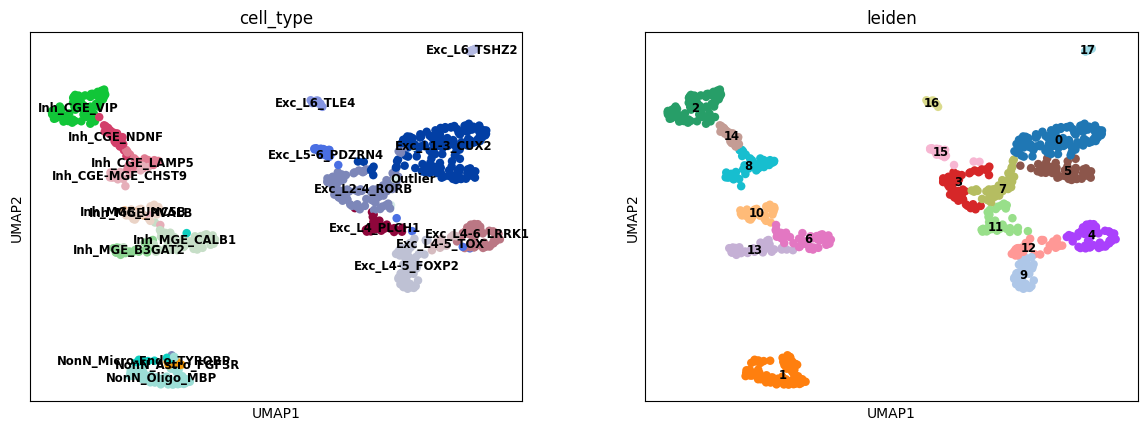

In [16]:
sc.tl.umap(M2R_predict)
sc.tl.leiden(M2R_predict)
sc.pl.umap(M2R_predict, color=['cell_type', 'leiden'], legend_loc='on data', legend_fontsize='small')

In [17]:
ARI, AMI, NMI, HOM = calculate_cluster_index(M2R_predict)
print('DNAm to RNA:\nARI: %.3f, \tAMI: %.3f, \tNMI: %.3f, \tHOM: %.3f' % (ARI, AMI, NMI, HOM))

DNAm to RNA:
ARI: 0.669, 	AMI: 0.828, 	NMI: 0.842, 	HOM: 0.859


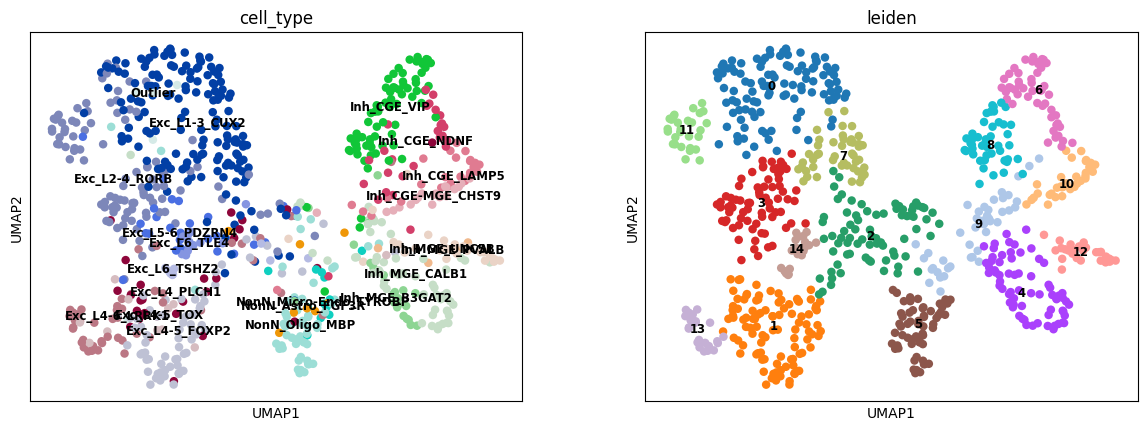

In [18]:
sc.tl.umap(R2M_predict)
sc.tl.leiden(R2M_predict)
sc.pl.umap(R2M_predict, color=['cell_type', 'leiden'], legend_loc='on data', legend_fontsize='small')

In [19]:
ARI, AMI, NMI, HOM = calculate_cluster_index(R2M_predict)
print('RNA to DNAm:\nARI: %.3f, \tAMI: %.3f, \tNMI: %.3f, \tHOM: %.3f' % (ARI, AMI, NMI, HOM))

RNA to DNAm:
ARI: 0.397, 	AMI: 0.573, 	NMI: 0.604, 	HOM: 0.596
